# Data cleaning

This notebook reads following raw datasets for cleaning and completing the data:
1. Royal Netherlands Meteorological Institute (KNMI)
2. Hourly electricity consumption data of non-residential buildings in the Netherlands (four offices and one school)

The electricity consumption data of non-residential buildings is collected by Croonwolter&dros and made anonymous for this project. Further details of the sites is mentioned below.

In [500]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. Prepare Climate Data

The CSV file is read in the Microsoft Excel and columns are renamed. After checking the completeness of data, it is read in this python script.
Data source: [Royal Netherlands Meteorological Institute (KNMI)](https://www.tudelft.nl/?id=59090&L=1)

In [501]:
# Read data
data = pd.read_excel('raw/Climate350.xlsx')

In [502]:
data.drop(data.index[1416:1440], inplace=True)  # drop rows

In [503]:
# Format data
data['Local'] = [item.strip('"') for item in data['Local']]
data['ID'] = [item.strip('"') for item in data['ID']]
data['Azimuth [Degrees]'] = [item.strip('"') for item in data['Azimuth [Degrees]']]
data['Local'] = [item.replace('0000', '2021') for item in data['Local']]
data.index = data['ID']
data.drop(['ID'], axis=1, inplace=True)

In [504]:
# Convert to datetime
data['Local'] = pd.to_datetime(data['Local'], format='%Y-%m-%d %H:%M:%S')
df = data.set_index('Local')

In [505]:
# Extract dates in a column for easier handling
date = [datetime.datetime.strptime(str(index), '%Y-%m-%d %H:%M:%S').date() for index, row in df.iterrows()]
df['date'] = date

In [506]:
# Resample data to 15 minutes
df = df.resample('15Min').asfreq().fillna(method='ffill')

Plot key parameters to be used in the model.

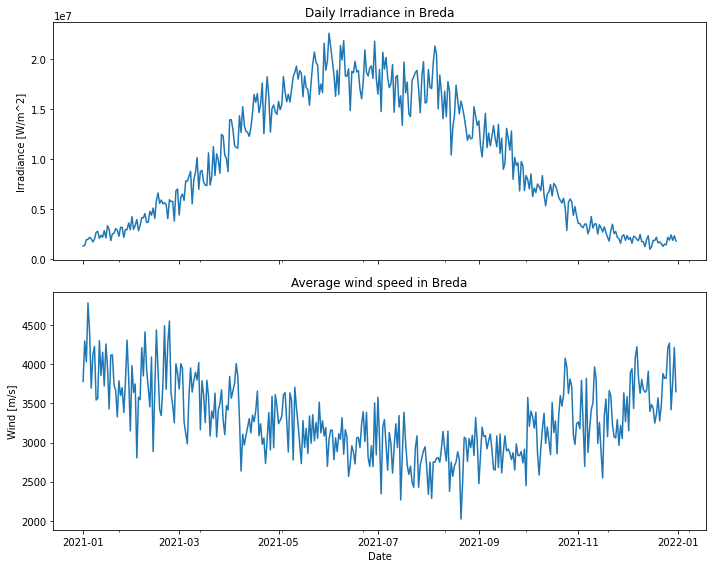

In [507]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
df.groupby('date')['Irradiance [W/m^2]'].sum().plot(ax=axs[0])
df.groupby('date')['Wind [m/s]'].mean().plot(ax=axs[1])
axs[0].set_ylabel('Irradiance [W/m^2]')
axs[0].set_xlabel('Date')
axs[0].set_title('Daily Irradiance in Breda')
axs[1].set_ylabel('Wind [m/s]')
axs[1].set_xlabel('Date')
axs[1].set_title('Average wind speed in Breda')
plt.tight_layout()

In [508]:
climate_df = df.copy() # save a copy of the dataframe

## 2. Prepare Electricity Consumption Data

In [509]:
def reset_date_index(df, date):
    """ Reset the index of the dataframe to a date.
    :arg df: dataframe
    :arg date: date
    :return: dataframe
    """
    df = df.reset_index()
    df['index'] = df['index'].astype(str)
    df['index'] = df['index'].apply(lambda x: str(date) + ' '+ x)
    df['index'] = pd.to_datetime(df['index'])
    df.set_index('index', drop=True, inplace=True)
    return df

Following are the details of anonymous data.
1. Office 1
    * Area: 9375 m2
    * location: Handelsweg, NL
2. Office 2
    * Area: 8808 m2
    * location: Eindhoven, Limburglaan, NL
3. Office 3
    * Area: 3500 m2
    * location: Maastricht Afrikalaan, NL
4. Office 4
    * Area: 13500 m2
    * location: Heerlen, NL
5. School
    * Area: 27000 m2
    * location: Heerhugowaard, NL

In [510]:
#read data
df = pd.read_csv('raw/DataExport095911.csv', delimiter=';', decimal=',', parse_dates=['Tijdstip vanaf'])

In [511]:
# Convert to datetime
df['Tijdstip vanaf'] = pd.to_datetime(df['Tijdstip vanaf'], format='%Y-%m-%d %H:%M:%S')
df.rename(columns={'Tijdstip vanaf': 'Local'}, inplace=True)
df = df.set_index('Local')

In [512]:
# Extract dates in a column for easier handling
date = [datetime.datetime.strptime(str(index), '%Y-%m-%d %H:%M:%S').date() for index, row in df.iterrows()]
df['date'] = date

Check the completeness of the data

In [513]:
columns = df.columns.to_list()
columns = columns[0:-2]
index = df[df[columns].isna().any(axis=1)].index
print(index)

DatetimeIndex(['2021-03-28 01:45:00', '2021-03-28 02:00:00',
               '2021-03-28 02:15:00', '2021-03-28 02:30:00'],
              dtype='datetime64[ns]', name='Local', freq=None)


Above data points are missing from the same day. Therefore, electricity consumption data for 2021-01-28 is replaced with the electricity consumption data for 2021-01-21.

In [514]:
# Replace missing data with previous week's data
for i, row in df.loc[index, columns].iterrows():
    df.loc[i, :] = df.loc[i - datetime.timedelta(days=7), :]

In [515]:
# Perform completeness check again for four sites
index = df[df[columns].isna().any(axis=1)].index
print(index)

DatetimeIndex([], dtype='datetime64[ns]', name='Local', freq=None)


Now, managing the incomplete data for site 5 i.e. school.

In [516]:
columns = df.columns.to_list()[4]

In [517]:
for month in np.arange(1, 13):
    # Get all the values for the month
    df_m = pd.DataFrame(df[df[columns].index.month == month][columns])
    # Subset based on week day and weekend
    df_weekday = df_m[df_m.index.weekday.isin([1, 2, 3, 4, 5])]
    df_weekend = df_m[df_m.index.weekday.isin([6, 0])]
    # Calculate average weekday consumption
    avg_weekday = df_weekday.groupby(df_weekday.index.time).mean()
    # Calculate average weekend consumption
    avg_weekend = df_weekend.groupby(df_weekend.index.time).mean()
    # Create dataframe with average consumption for each hour
    avg_consumption = pd.DataFrame(columns= ['weekday', 'weekend'])
    avg_consumption['weekday'] = avg_weekday
    avg_consumption['weekend'] = avg_weekend
    # Get dates of missing data in the weekend
    dates_missing_data = np.unique(df_m[df_m.isna()].index.date)
    # Replace missing data with average weekday/weekend consumption
    for date in dates_missing_data:
        filler_value = reset_date_index(avg_consumption,date)
        if int(date.weekday()) in [6, 0]:
            df_m.loc[str(date), columns] = filler_value['weekend']
        else:
            df_m.loc[str(date), columns] = filler_value['weekday']
    # Add the complete monthly data to the main dataframe
    df.loc[df[columns].index.month == month, columns] = df_m[columns]

Lastly, the school data has some faulty readings in form of outliers. Therefore, those faulty readings are replaced with the energy consumption of previous time step (i.e. 15 minutes ago).

In [518]:
for index, row in df.loc[df[columns] > 75,:].iterrows():
    df.loc[index, columns] = df.loc[index - datetime.timedelta(minutes=-15), columns]

In [519]:
# Perform completeness check again for all sites
df.isnull().sum()

Office 1    0
Office 2    0
Office 3    0
Office 4    0
School      0
date        0
dtype: int64

Hence, data is complete for all sites.

Text(0, 0.5, 'Consumption [kWh]')

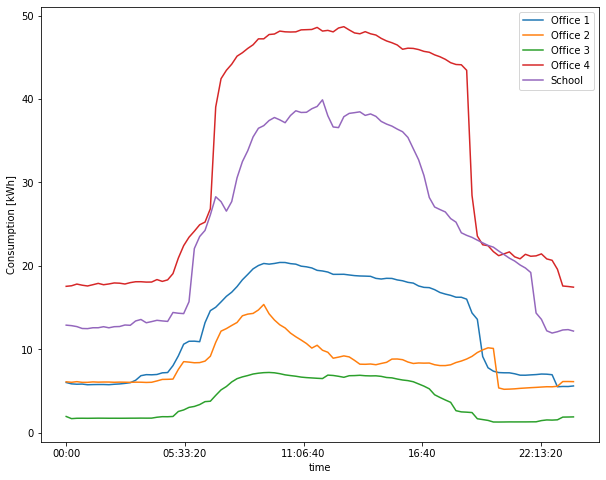

In [520]:
fig, ax = plt.subplots(figsize=(10, 8))
df.groupby(df.index.time).mean().plot(ax = ax, legend=True)
ax.set_ylabel('Consumption [kWh]')

In [521]:
df_non_commercial = df.copy()

## 3. Combine datasets

In [522]:
df = pd.merge(df_non_commercial, climate_df, left_index=True, right_index=True)

In [523]:
# Checking data completeness
df.isnull().sum()

Office 1                       0
Office 2                       0
Office 3                       0
Office 4                       0
School                         0
date_x                         0
Irradiance [W/m^2]             0
T_ambient [Degrees Celsius]    0
T_ground [Degrees Celsius]     0
Wind [m/s]                     0
Cloud [okta]                   0
Pressure [Pa]                  0
Rain [mm/hr]                   0
Diffuse [W/m^2]                0
Direct [W/m^2]                 0
Elevation [Degrees]            0
Azimuth [Degrees]              0
date_y                         0
dtype: int64

Store the data as a csv file

## 4. Save data

In [524]:
# Save the data to a csv file.
df.to_csv('processed/cleaned_data.csv')